# Creating a map of street designations

## Loading data

In [136]:
from geopandas import GeoDataFrame

%matplotlib inline

Load data from shapefile downloaded from http://download.geofabrik.de/

In [137]:
city_id = 'spb'

if city_id == 'moscow':
    city_name_english = 'Moscow'
    city_name_russian = 'Москва'
elif city_id == 'spb':
    city_name_english = 'Saint Petersburg'
    city_name_russian = 'Санкт-Петербург'

shp_path = 'gis_osm_roads_free_1.shp'
roads = GeoDataFrame.from_file(shp_path, encoding='utf-8')
roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,4078548,5122,residential,Шепетовская улица,None,F,60,0,F,F,"LINESTRING (30.41413 59.94706, 30.41419 59.947..."
1,4391341,5141,service,None,None,F,0,0,F,F,"LINESTRING (33.07200 68.97181, 33.07184 68.971..."
2,4391345,5115,tertiary,Комсомольская улица,None,B,0,0,F,F,"LINESTRING (33.06562 68.96837, 33.06587 68.968..."
3,4391346,5113,primary,проспект Ленина,None,B,60,0,F,F,"LINESTRING (33.09047 68.95031, 33.08994 68.95057)"
4,4391347,5114,secondary,улица Полярные Зори,None,B,60,0,F,F,"LINESTRING (33.09934 68.96778, 33.09886 68.967..."


Define bounding box

In [138]:
if city_id == 'moscow':
    center = [55.75, 37.61]
    top = 55.95
    bottom = 55.55
    left = 37.36
    right = 37.86
elif city_id == 'spb':
    center = [59.94, 30.10]
    top = 60.10
    bottom = 59.81
    left = 29.64
    right = 30.56

Create a bounding ellipse for city limits

In [139]:
import folium
import shapely.affinity
from shapely.geometry import Point
import geopy.distance

if city_id == 'moscow':
    kilometers_lat = 21
    kilometers_lon = 17
elif city_id == 'spb':
    kilometers_lat = 21
    kilometers_lon = 28

# create an ellipse
radius_lat = geopy.distance.distance(kilometers = kilometers_lat).destination(point=center, bearing=0)[0] - center[0]
radius_lon = geopy.distance.distance(kilometers = kilometers_lon).destination(point=center, bearing=90)[1] - center[1]

circle = Point(center[::-1]).buffer(1)
ellipse = shapely.affinity.scale(circle, radius_lon, radius_lat)

ellipse_map = folium.Map(location=center, zoom_start=10, tiles='CartoDB positron')

folium.PolyLine(list([c[::-1] for c in ellipse.exterior.coords])).add_to(ellipse_map)

ellipse_map

Select only roads in bounding ellipse

In [140]:
city = roads.loc[roads['geometry'].apply(lambda g: ellipse.contains(g))].copy()
city.shape

(225647, 11)

Select only roads that have a name or roads that are classified as trunk or primary. Set empty string as name for streets that don't have names.

In [141]:
city = city[city.fclass.isin(['trunk', 'primary']) | city['name'].notnull()]
city['name'] = city['name'].fillna(value='')
city.shape

(21408, 11)

## Define street designations

Now to define street designations. In Russian, street designations can precede the name (*улица* Пестеля) or follow the name (Малая Грузинская *улица*) or even come in the middle if the street has a number (1-я *улица* Энтузиастов). Let's identify the prefixes and postfixes to find possible street designations.

In [142]:
city['prefix'] = city['name'].apply(lambda name: name.split(' ')[0] if name is not None else None)
city['postfix'] = city['name'].apply(lambda name: name.split(' ')[-1] if name is not None else None)

Find designations in street names. I've singled out "вал" (rampart) since many streets carry this designation to remind of old fortification lines.

| Russian | English |
| --- | --- |
| переулок | lane |
| улица | street |
| вал | rampart |
| проезд | drive |
| проспект | avenue |
| шоссе | highway |
| площадь | square |
| набережная | embankment |
| бульвар | boulevard |
| тупик | close |
| магистраль | motorway |

In [143]:
def get_designation(name, others):
    name = name.lower()
    if 'переулок' in name: return 'переулок'
    elif ' вал' in name: return 'вал'
    elif 'улица' in name: return 'улица'
    elif 'проезд' in name: return 'проезд'
    elif 'проспект' in name: return 'проспект'
    elif 'шоссе' in name: return 'шоссе'
    elif 'площадь' in name: return 'площадь'
    elif 'набережная' in name: return 'набережная'
    elif 'бульвар' in name: return 'бульвар'
    elif 'аллея' in name or 'ал.' in name: return 'аллея'
    elif 'тупик' in name: return 'тупик'
    elif city_id == 'moscow':
        if any(ext in name for ext in ['мкад', 'третье транспортное', 'хорда', 'тоннель', 'путепровод', 'эстакада', 'рокада']):
            return 'магистраль'   
    elif city_id == 'spb':
        if any(ext in name for ext in ['кад', 'зсд', 'тоннель', 'путепровод']):
            return 'магистраль'
        if 'линия' in name or 'линии' in name:
            return 'линия'
        if 'дорога' in name:
            return 'дорога'
        if 'мост' in name:
            return 'мост'
        if 'дорожка' in name:
            return 'дорожка'
        if 'канал' in name:
            return 'канал'
    others.add(name)
    return 'остальные'

In [144]:
others = set()
city['designation'] = [get_designation(name, others) for name in city['name']]

In [145]:
print(city.designation.value_counts())
print(list(others)[:50])

улица         9340
проспект      4564
шоссе         1314
набережная     980
переулок       907
магистраль     897
площадь        585
мост           489
линия          424
аллея          422
остальные      345
проезд         329
дорога         321
дорожка        244
бульвар        207
канал           23
вал             11
тупик            6
Name: designation, dtype: int64
['', 'фарфоровский пост', 'лестница 3', 'константин', 'южный подуличный переход', 'тропа', 'манежный спуск', 'купальный спуск', 'иликовская першпектива', '1-я конная лахта', 'станция нева', 'петровская коса', 'лестница 4', 'подземный переход', 'внутреннее кольцо', 'дунькина горка', 'тропический маршрут', 'хмелевая веранда', '2-я конная лахта', 'сойкино-пеники', 'сортавала', 'экологическая тропа', 'северный подуличный переход', 'ораниенбаумский спуск', 'лестница 1', 'санкт-петербург — матокса', 'форт константин', 'суворовский городок', 'румянцевский спуск', 'лестница 2', 'грин стрит', 'въезд на территорию машоптторг (гр

In [146]:
city.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,prefix,postfix,designation
0,4078548,5122,residential,Шепетовская улица,None,F,60,0,F,F,"LINESTRING (30.41413 59.94706, 30.41419 59.947...",Шепетовская,улица,улица
570,4454283,5114,secondary,Парашютная улица,None,F,60,0,F,F,"LINESTRING (30.29180 60.01548, 30.29328 60.015...",Парашютная,улица,улица
571,4454334,5115,tertiary,Екатерининский проспект,None,F,60,0,F,F,"LINESTRING (30.44069 59.98376, 30.44054 59.983...",Екатерининский,проспект,проспект
572,4454357,5115,tertiary,Виндавская улица,None,B,60,0,F,F,"LINESTRING (30.25169 59.91075, 30.25169 59.910...",Виндавская,улица,улица
573,4454376,5113,primary,Зоологический переулок,None,F,60,0,F,F,"LINESTRING (30.30432 59.94792, 30.30477 59.948...",Зоологический,переулок,переулок


## Plotting maps

Define colors and English variants for street types.

In [147]:
names_english = {
    'улица': 'street',
    'шоссе': 'highway',
    'проспект': 'avenue',
    'магистраль': 'motorway',
    'набережная': 'embankment',
    'бульвар': 'boulevard',
    'аллея': 'alley',
    'переулок': 'lane',
    'тупик': 'close',
    'площадь': 'square',    
    'вал': 'rampart',
    'проезд': 'drive',
    'линия': 'line',
    'дорога': 'road',
    'мост': 'bridge',
    'дорожка': 'path',
    'канал': 'channel',
    'остальные': 'others'
}
if city_id == 'moscow':
    colors = {
        'улица': '#59c8e5',
        'площадь': '#59c8e5',
        'переулок': '#fed032',
        'тупик': '#fec301',
        'проезд': '#fe4d64',
        'проспект': '#ffb366',
        'шоссе': '#ff9223',
        'магистраль': '#e67300',
        'набережная': '#0a7abf',
        'аллея': '#45cea2',
        'бульвар': '#4cb580',
        'вал': '#2e968c',
        'остальные': '#cccccc'
    }
elif city_id == 'spb':
    colors = {
        'улица': '#59c8e5',
        'площадь': '#59c8e5',
        'линия': '#9370d8',
        'переулок': '#fed032',
        'тупик': '#fec301',
        'проезд': '#fe4d64',
        'дорога': '#fe4d64',
        'проспект': '#ffb366',
        'шоссе': '#ff9223',
        'магистраль': '#e67300',
        'набережная': '#0a7abf',
        'канал': '#0a7abf',
        'дорожка': '#45cea2',
        'аллея': '#45cea2',
        'бульвар': '#4cb580',
        'вал': '#2e968c',
        'мост': '#2e968c',
        'остальные': '#cccccc'
    }

Create a plot using Matplotlib and save as png (Russian and English versions).

In [148]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_and_save(
    top,
    bottom,
    left,
    right,
    linewidth,
    linewidth_lane,
    legend_title,
    legend_bbox,
    path,
    english=False,
    dpi=300
    ):

    plt.style.use('classic')
    f, ax = plt.subplots(1, figsize=(15, 15))

    city.plot(ax=ax,
                color=[colors[d] for d in city.designation],
                linewidth=[linewidth if d != 'переулок' else linewidth_lane for d in city.designation])
    ax.set_aspect(1/math.cos(math.pi/180*center[0]))
    ax.set_ylim((bottom, top))
    ax.set_xlim((left, right))


    plt.axis('off')
    
    plt.legend(handles=[mpatches.Patch(color=colors[k], 
                                       label=f'{names_english[k]}' if english else k) for k in colors],
               loc='center right',
               fontsize='large',
               edgecolor='none',
               title=legend_title,
               title_fontsize='xx-large',
               bbox_to_anchor=legend_bbox)

    plt.savefig(path, bbox_inches='tight', dpi=dpi)

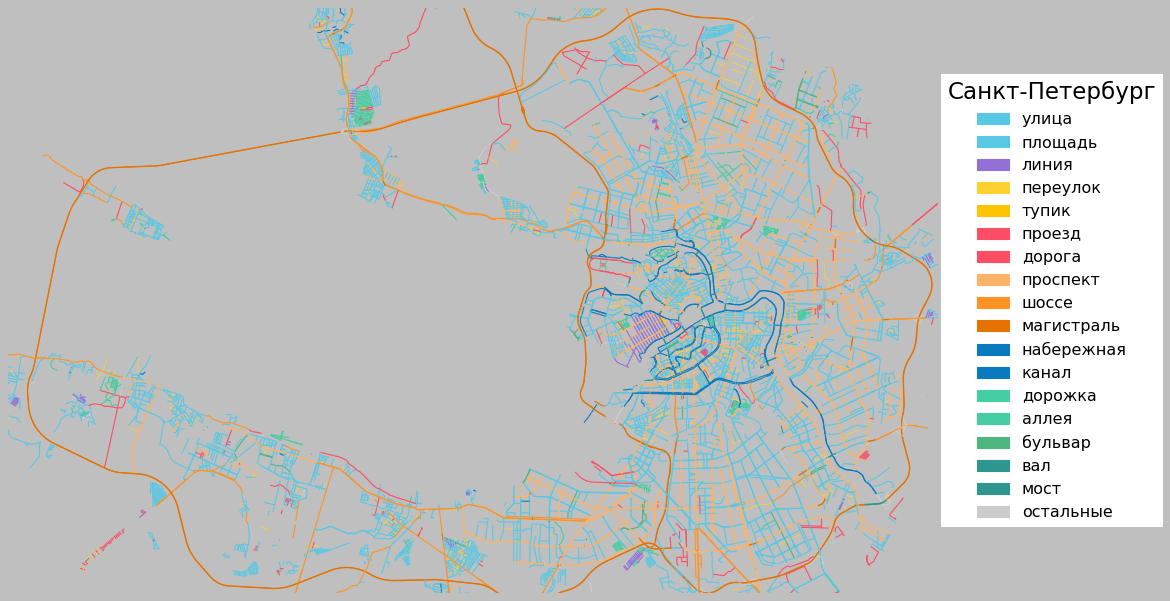

In [149]:
plot_and_save(top,
              bottom,
              left,
              right,
              1,
              0.7,
              city_name_russian,
              (1.25, 0.5),
              'images/{}_russian.png'.format(city_id))

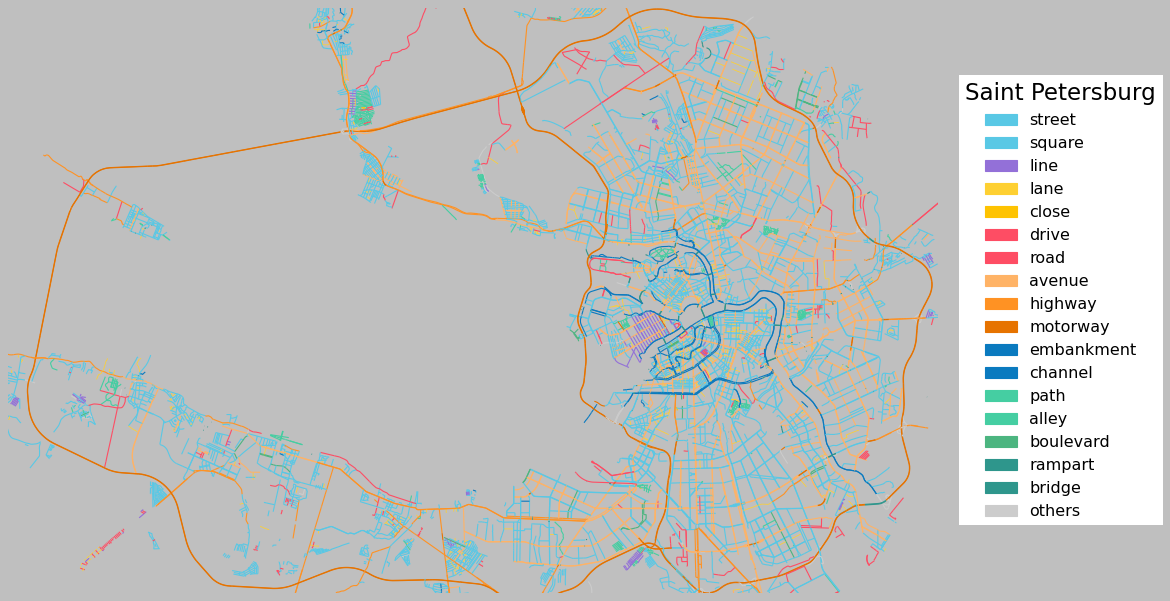

In [150]:
plot_and_save(top,
              bottom,
              left,
              right,
              1,
              0.7,
              city_name_english,
              (1.25, 0.5),
              'images/{}_english.png'.format(city_id),
              True)

Create zoomed in map of city center

In [151]:
if city_id == 'moscow':
    top_center = 55.82
    bottom_center = 55.70
    left_center = 37.53
    right_center = 37.72
elif city_id == 'spb':
    top_center = 59.984
    bottom_center = 59.908
    left_center = 30.23
    right_center = 30.40

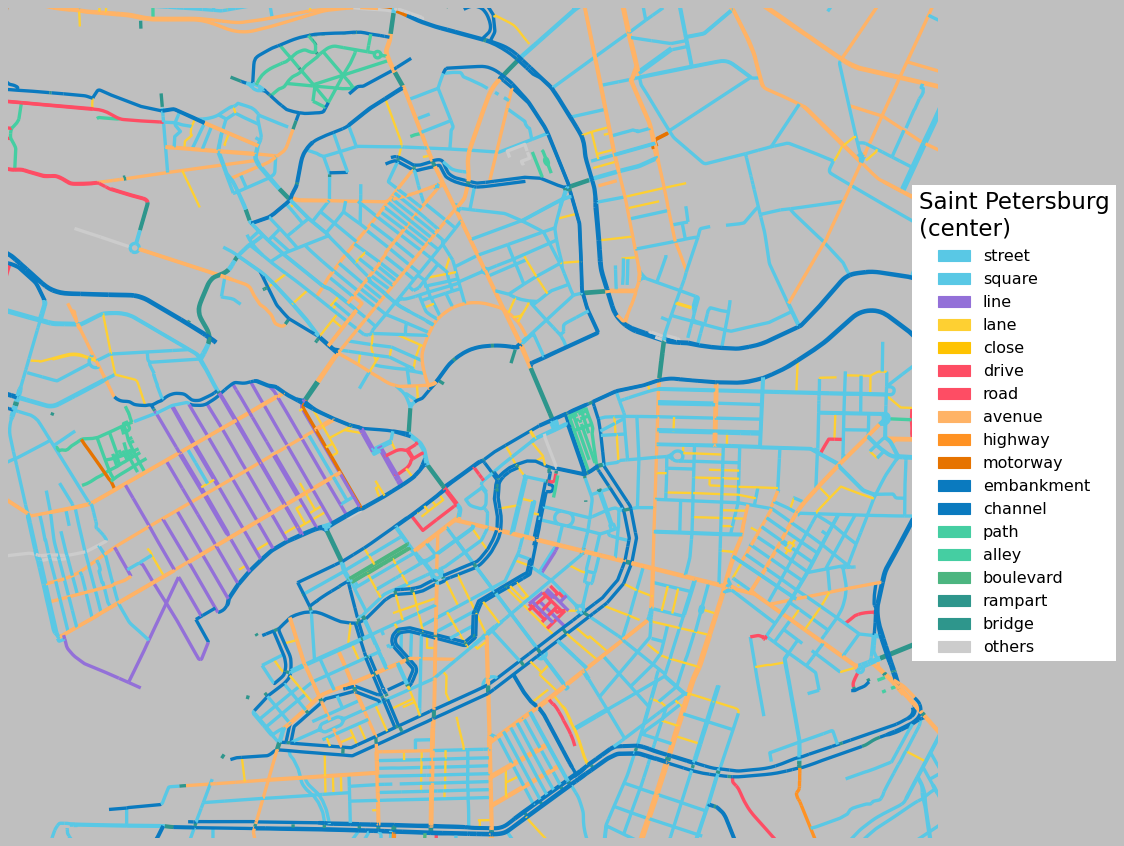

In [152]:
plot_and_save(top_center,
             bottom_center,
             left_center,
             right_center,
             3,
             2.1,
             '{}\n(center)'.format(city_name_english),
             (1.2, 0.5),
             'images/{}_center_english.png'.format(city_id),
             True)

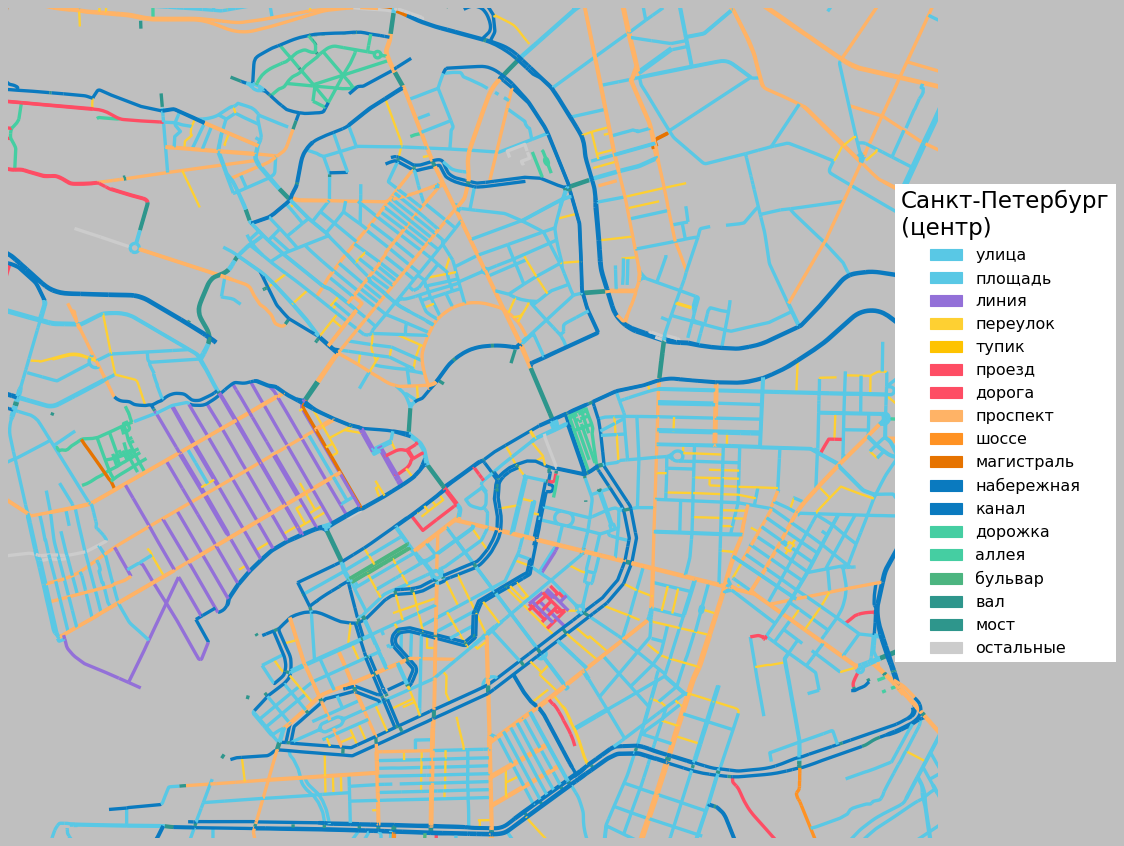

In [153]:
plot_and_save(top_center,
             bottom_center,
             left_center,
             right_center,
             3,
             2.1,
             '{}\n(центр)'.format(city_name_russian),
             (1.2, 0.5),
             'images/{}_center_russian.png'.format(city_id))

Create interactive map with Folium

In [154]:
streets_map = folium.Map(location=center, zoom_start=10, tiles='CartoDB positron')

for i, street in city.iterrows():
    weight = 2
    if 'переулок' in street['name']:
        weight = 1    
    folium.PolyLine(
        [c[::-1] for c in street.geometry.coords],
        color=colors[street['designation']],
        popup=street['name'],
        weight=weight
        ).add_to(streets_map)

streets_map.save('{}/index.html'.format(city_id))